ImageNet

In [1]:
from IPython.display import Image, display


Displaying image: apple.jpg


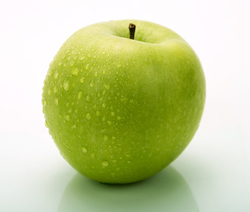


Displaying image: clock.jpg


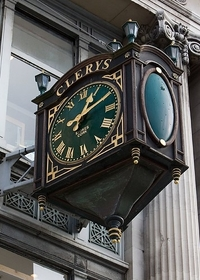


Displaying image: oranges.jpg


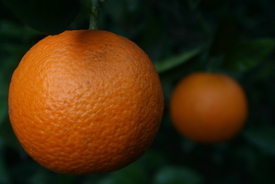


Displaying image: car.jpg


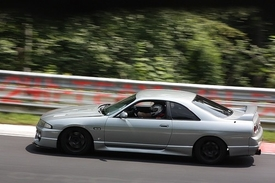

In [2]:
# Some example images
image_files = [
    'apple.jpg',
    'clock.jpg',
    'oranges.jpg',
    'car.jpg'
]

for image_file in image_files:
    print(f"\nDisplaying image: {image_file}")
    display(Image(filename=f"images/{image_file}"))

In [3]:
import os

dir_name = "images_with_boxes"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

We will use the detect_common_objects function, which takes an image formatted as a numpy array and returns:

bbox: list of list containing bounding box coordinates for detected objects.

  Example:

[[32, 76, 128, 192], [130, 83, 220, 185]]
label: list of labels for detected objects.

  Example:
['apple', 'apple']
conf: list of confidence scores for detected objects.

  Example:

[0.6187325716018677, 0.42835739254951477]
In the next section you will visually see these elements in action.

In [7]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox


def detect_and_draw_box(filename, model="yolov3-tiny", confidence=0.5):
    """Detects common objects on an image and creates a new image with bounding boxes.

    Args:
        filename (str): Filename of the image.
        model (str): Either "yolov3" or "yolov3-tiny". Defaults to "yolov3-tiny".
        confidence (float, optional): Desired confidence level. Defaults to 0.5.
    """
    
    # Images are stored under the images/ directory
    img_filepath = f'images/{filename}'
    
    # Read the image into a numpy array
    img = cv2.imread(img_filepath)
    
    # Perform the object detection
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    
    # Print current image's filename
    print(f"========================\nImage processed: {filename}\n")
    
    # Print detected objects with confidence level
    for l, c in zip(label, conf):
        print(f"Detected object: {l} with confidence level of {c}\n")
    
    # Create a new image that includes the bounding boxes
    output_image = draw_bbox(img, bbox, label, conf)
    
    # Save the image in the directory images_with_boxes
    cv2.imwrite(f'images_with_boxes/{filename}', output_image)
    
    # Display the image with bounding boxes
    display(Image(f'images_with_boxes/{filename}'))

Let's try it out for the example images.

Image processed: apple.jpg

Detected object: apple with confidence level of 0.5717207193374634



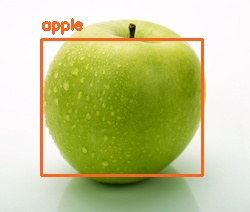

Image processed: clock.jpg

Detected object: clock with confidence level of 0.9683184623718262



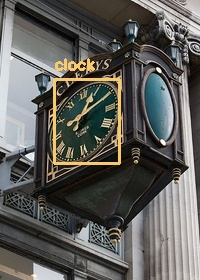

Image processed: oranges.jpg

Detected object: orange with confidence level of 0.6185588240623474

Detected object: orange with confidence level of 0.5561691522598267



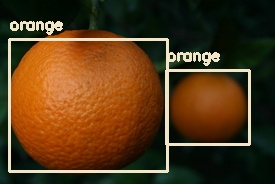

Image processed: car.jpg

Detected object: car with confidence level of 0.6325408816337585



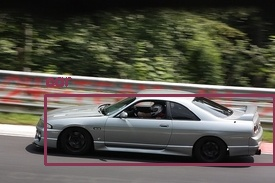

In [9]:
for image_file in image_files:
    detect_and_draw_box(image_file)

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818484425544739

Detected object: orange with confidence level of 0.5346481800079346

Detected object: orange with confidence level of 0.5150994658470154



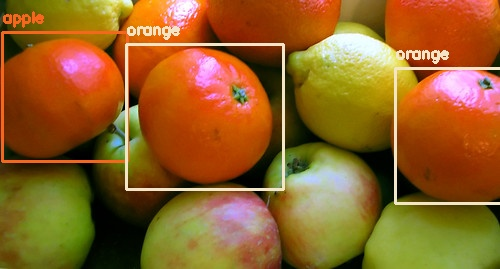

In [10]:
#failed
detect_and_draw_box("fruits.jpg")

It is more accurate now but Confidence is low.

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818484425544739

Detected object: orange with confidence level of 0.5346481800079346

Detected object: orange with confidence level of 0.5150994658470154

Detected object: apple with confidence level of 0.3475988507270813

Detected object: orange with confidence level of 0.32876113057136536

Detected object: apple with confidence level of 0.3124468922615051

Detected object: orange with confidence level of 0.2798609137535095

Detected object: orange with confidence level of 0.27499765157699585

Detected object: apple with confidence level of 0.2744506001472473

Detected object: orange with confidence level of 0.21419109404087067



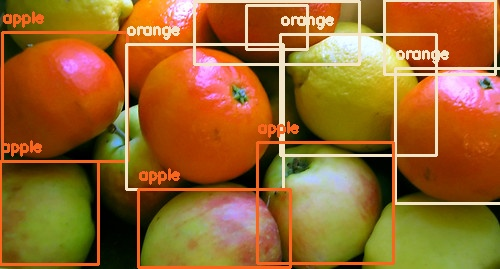

In [11]:
detect_and_draw_box("fruits.jpg", confidence=0.2)

Deploying the model using fastAPI
Placing your object detection model in a server

In [12]:
dir_name = "images_uploaded"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

In [14]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

In [15]:
# Assign an instance of the FastAPI class to the variable "app".
# You will interact with your api using this instance.
app = FastAPI(title='Deploying a ML Model with FastAPI')

# List available models using Enum for convenience. This is useful when the options are pre-defined.
class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"


# By using @app.get("/") you are allowing the GET method to work for the / endpoint.
@app.get("/")
def home():
    return "Congratulations! Your API is working as expected. Now head over to http://localhost:8000/docs."


# This endpoint handles all the logic necessary for the object detection to work.
# It requires the desired model and the image in which to perform object detection.
@app.post("/predict") 
def prediction(model: Model, file: UploadFile = File(...)):

    # 1. VALIDATE INPUT FILE
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    # 2. TRANSFORM RAW IMAGE INTO CV2 image
    
    # Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Start the stream from the beginning (position zero)
    image_stream.seek(0)
    
    # Write the stream of bytes into a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    
    # 3. RUN OBJECT DETECTION MODEL
    
    # Run object detection
    bbox, label, conf = cv.detect_common_objects(image, model=model)
    
    # Create image that includes bounding boxes and labels
    output_image = draw_bbox(image, bbox, label, conf)
    
    # Save it in a folder within the server
    cv2.imwrite(f'images_uploaded/{filename}', output_image)
    
    
    # 4. STREAM THE RESPONSE BACK TO THE CLIENT
    
    # Open the saved image for reading in binary mode
    file_image = open(f'images_uploaded/{filename}', mode="rb")
    
    # Return the image as a stream specifying media type
    return StreamingResponse(file_image, media_type="image/jpeg")

In [16]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# Host depends on the setup you selected (docker or virtual env)
host = "0.0.0.0" if os.getenv("DOCKER-SETUP") else "127.0.0.1"

# Spin up the server!    
uvicorn.run(app, host=host, port=8000)

INFO:     Started server process [16600]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:58932 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:58933 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:58938 - "GET /docs. HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:58940 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:58937 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:58937 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:58971 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [16600]
